1️⃣ Use Hierarchical Forecasting   
  
What It Is   
	•	Hierarchical forecasting aggregates data at higher levels (e.g., brand level or total sales) to compensate for sparsity at lower levels (e.g., brand + family).   
	•	Predictions are made at the higher levels and disaggregated down to smaller groups (e.g., brand-family) using proportions.   
  
Steps to Implement   
	1.	Aggregate to Higher Levels:   
	•	Aggregate sparse brand-family data up to broader levels:   
	•	Brand level: brand_total_sales  
	•	Family level: family_total_sales  
	•	Overall total: global_total_sales  
	•	Use the aggregated time series to train the model.  
	2.	Forecast at Higher Levels:   
	•	Predict sales at the aggregated levels using richer historical data.  
	3.	Disaggregate Forecasts:  
	•	Split the higher-level forecasts back down to the brand-family level using historical proportions. For example:
$\text{brand\_family\_forecast} = \text{brand\_forecast} \times \frac{\text{brand\_family\_sales}}{\text{brand\_total\_sales}}$  
	4.	Smooth Proportions for Stability:  
	•	Use smoothed historical proportions (e.g., rolling averages) to prevent overfitting to noisy historical proportions.  



Steps in the Implementation  
	1.	Aggregate Sparse Data to Higher Levels (e.g., brand).    
	2.	Train a Forecasting Model at the Higher Level (e.g., using a simple statistical model or machine learning).    
	3.	Disaggregate Forecasts:    
	•	Use historical proportions to split higher-level forecasts back down to the brand + family level.  

In [1]:
import pandas as pd
import utils.utils_models as utils_models

import utils.utils_preprocessing as utils_preprocessing
import utils.utils_features as utils_features

In [2]:
df_sales = pd.read_parquet("data/sales.parquet")
df_products = pd.read_parquet("data/products.parquet")
df = df_sales.merge(df_products, on="product_id")

In [3]:
df = utils_preprocessing.set_types(df)
df = utils_preprocessing.filter_dates(df, date="2024-09-01")

df_monthly = utils_preprocessing.aggregate_data(
    df, 
    frequency="ME"
    )
df_monthly = utils_preprocessing.fill_in_missing_dates(
    df_monthly, 
    group_col=["brand", "family"], 
    date_col="date", 
    freq="ME"
    )
df_monthly = utils_features.features_time_related(
    df_monthly, 
    frequency='ME'
    )

In [4]:
df_monthly[df_monthly["total_revenue"]<0.1]

,brand,family,date,total_revenue,year,month_of_year,sin_month_of_year,cos_month_of_year
1696,adidas,Chanclas Urban,2022-09-30,0.0,2022,9,-1.000,-0.000
1697,adidas,Chanclas Urban,2022-10-31,0.0,2022,10,-0.866,0.500
1698,adidas,Chanclas Urban,2022-11-30,0.0,2022,11,-0.500,0.866
1699,adidas,Chanclas Urban,2022-12-31,0.0,2022,12,-0.000,1.000
1700,adidas,Chanclas Urban,2023-01-31,0.0,2023,1,0.500,0.866
1701,adidas,Chanclas Urban,2023-02-28,0.0,2023,2,0.866,0.500
2971,adidas,Sudaderas Training,2021-04-30,0.0,2021,4,0.866,-0.500
3338,adidas,Zapatillas Triatlón running,2022-02-28,0.0,2022,2,0.866,0.500
3339,adidas,Zapatillas Triatlón running,2022-03-31,0.0,2022,3,1.000,0.000
3340,adidas,Zapatillas Triatlón running,2022-04-30,0.0,2022,4,0.866,-0.500


In [5]:
# Use the last month of your dataset as the reference to split
train_end_date = df_monthly['date'].max() - pd.DateOffset(months=12)

# Split into training and test sets
train_data = df_monthly[df_monthly['date'] <= train_end_date]
test_data = df_monthly[df_monthly['date'] > train_end_date]
X_train, X_test, y_train, y_test = utils_preprocessing.train_test_split(df_monthly, forecasting_horizon=12, target_col="total_revenue")

In [6]:
# Compute proportions with historical data

# Step 2: Aggregate total revenue by date
df_revenue_agg = train_data.groupby('date')['total_revenue'].sum().reset_index()
df_revenue_agg.rename(columns={'total_revenue': 'total_revenue_agg'}, inplace=True)

# Step 3: Merge to calculate proportions
df_proportions = train_data.merge(df_revenue_agg, on='date')

# Step 4: Calculate the proportion for each brand/family
df_proportions['proportion'] = (
    df_proportions['total_revenue'] / df_proportions['total_revenue_agg']
)

# Final DataFrame with proportions
df_proportions = df_proportions[['date', 'brand', 'family', 'proportion']]

# Combine all the monthly proportions into a single DataFrame
df_proportions['month'] = df_proportions['date'].dt.month
df_proportions = df_proportions.drop(columns='date')
df_proportions = df_proportions.groupby(['brand', 'family', 'month'], as_index=False).agg({'proportion': 'mean'})

In [19]:
# Predict with aggregated data

hyperparameters = {
    "order": (1, 1, 1),            
    "seasonal_order": (1, 1, 1, 12),  
    "steps_ahead": 12       
}

sarima_model = utils_models.SarimaForecastingModel(hyperparameters=hyperparameters)
sarima_model.train(X_train=None, y_train=train_data.groupby('date')['total_revenue'].sum()) 
sarima_result = sarima_model.predict(X=None) 

df_predictions_agg = sarima_result.reset_index()
df_predictions_agg.columns = ['date', 'forecast_total_revenue']
df_predictions_agg['month'] = df_predictions_agg['date'].dt.month

# Add the ground truth

# df_test_agg = test_data.groupby('date')['total_revenue'].sum().reset_index()
# df_test_agg.rename(columns={'total_revenue': 'total_revenue_agg'}, inplace=True)
# df_predictions_agg = df_predictions_agg.merge(df_test_agg, on='date')

/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [22]:
df_predictions_agg

,date,forecast_total_revenue,month
0,2023-09-30,80007.228973,9
1,2023-10-31,78007.842938,10
2,2023-11-30,129691.418471,11
3,2023-12-31,129367.894551,12
4,2024-01-31,124284.653645,1
5,2024-02-29,92738.672638,2
6,2024-03-31,101125.509845,3
7,2024-04-30,99445.591570,4
8,2024-05-31,97812.680040,5
9,2024-06-30,80088.513722,6


In [34]:
hyperparameters = {
    "trend": "mul",           # Additive trend component
    "seasonal": "mul",        # Multiplicative seasonality
    "seasonal_periods": 12,   # Number of periods in a season (e.g., 12 for monthly data)
    "steps_ahead": 12,        # Number of periods to forecast ahead
}

exp_smoothing_model = utils_models.ExponentialSmoothingForecastingModel(hyperparameters)
exp_smoothing_model.train(X_train=None, y_train=train_data.groupby('date')['total_revenue'].sum())
predictions = exp_smoothing_model.predict(None)

df_predictions_agg = predictions.reset_index()
df_predictions_agg.columns = ['date', 'forecast_total_revenue']
df_predictions_agg['month'] = df_predictions_agg['date'].dt.month

# Add the ground truth
df_test_agg = test_data.groupby('date')['total_revenue'].sum().reset_index()
df_test_agg.rename(columns={'total_revenue': 'total_revenue_agg'}, inplace=True)
df_predictions_agg = df_predictions_agg.merge(df_test_agg, on='date')

/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/matteogiaretti/Python/use_case_deporvillage/.venv/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='date'>

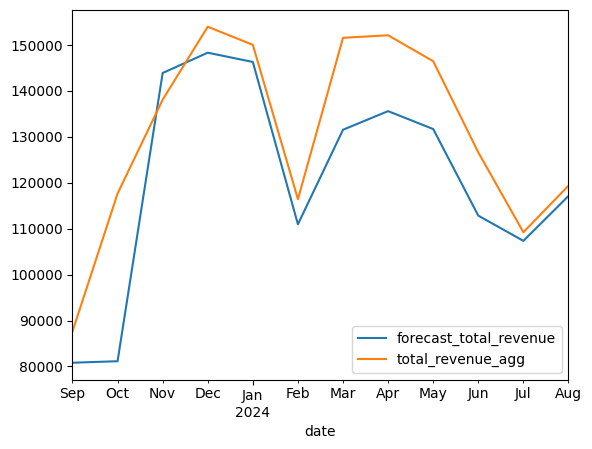

In [35]:
df_predictions_agg.set_index('date').sort_index().drop('month', axis=1).plot()

<Axes: xlabel='date'>

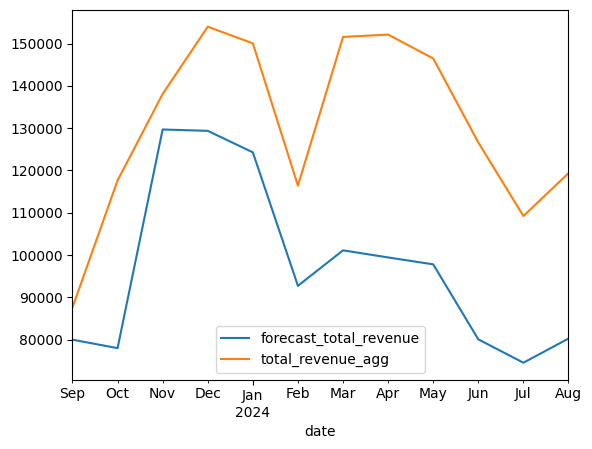

In [25]:
df_predictions_agg.set_index('date').sort_index().drop('month', axis=1).plot()

In [36]:
# Redistribute using proportions

df_predictions = X_test.reset_index()[['date', 'brand', 'family']].merge(df_predictions_agg, on='date', how='left')
df_predictions = df_predictions.merge(df_proportions, on=['brand', 'family', 'month'], how='left')

df_predictions['forecast_revenue'] = (
    df_predictions['forecast_total_revenue'] * df_predictions['proportion']
)
df_predictions = df_predictions[['date', 'brand', 'family', 'forecast_revenue']]

df_predictions = df_predictions.fillna(0)

In [37]:
actual_vs_forecast = pd.merge(test_data[['date', 'brand', 'family', 'total_revenue']], df_predictions, on=['date', 'brand', 'family'], how='left')
sarima_model.evaluate(actual_vs_forecast["total_revenue"], actual_vs_forecast["forecast_revenue"])

np.float64(1871.402)

<Axes: >

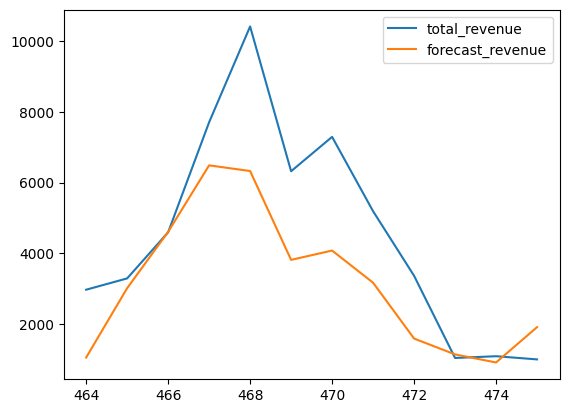

In [38]:
family = "Chándales Urban"
brand = "adidas"
actual_vs_forecast[(actual_vs_forecast["family"] == family) & (actual_vs_forecast["brand"] == brand)][["total_revenue", "forecast_revenue"]].plot()